In [1]:
import numpy as np
from numpy import array, outer, trace, dot, pi, log, exp, sin, cos, sqrt, sign, log2, diag, eye, reshape
from scipy.linalg import eig, eigh, norm, svd, kron, expm, sqrtm
from scipy.stats import gaussian_kde, unitary_group
from scipy.optimize import minimize, curve_fit, root_scalar

from functools import reduce

from qiskit.quantum_info import Choi, diamond_norm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rc
matplotlib.rc('font', family='CMU Serif')
matplotlib.rcParams['mathtext.fontset'] = 'cm' 
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
s0 = np.array([[1],
               [0]])
s1 = np.array([[0],
               [1]])
P0 = np.array([[1., 0.],
               [0., 0.]]) # |0><0|
P1 = np.array([[0., 0.],
               [0., 1.]]) # |1><1|
X = np.array([[0.,1.],
              [1.,0.]]) # X Pauli matrix
Y = np.array([[0.,-1.j],
              [1.j, 0.]]) # Y Pauli matrix
Z = np.array([[1., 0.],
              [0.,-1.]]) # Z Pauli matrix
I = np.array([[1.,0.],
              [0.,1.]]) # 2x2 identity matrix
H = (X + Z) / sqrt(2)

In [3]:
def fidelity(A, B):
    res = reduce(dot, [sqrtm(A), B, sqrtm(A)])
    res = sqrtm(res)
    return trace(res).real**2

def trace_distance(A, B):
    sub = A - B
    return trace(sqrtm(dot(sub.conj().T, sub))).real #/ 2

In [4]:
def phi_generator(n_qubits, normalized=True):
    n_qubits_half = int(n_qubits / 2)
    d = 2**n_qubits_half
    basis = np.eye(d)
    phi_state = np.reshape(np.zeros(2**n_qubits), (2**n_qubits, -1))
    for vec in basis:
        phi_state += kron(np.reshape(vec, (d, -1)), np.reshape(vec, (d, -1)))
    if normalized == True:
        return phi_state / norm(phi_state)
    else:
        return phi_state

In [5]:
def depolarizing_channel(n_qubits, density_matrix, p, target_qubit):
    
    X_loc = [I] * n_qubits
    X_loc[target_qubit] = X
    X_loc = reduce(kron, X_loc)
    
    Y_loc = [I] * n_qubits
    Y_loc[target_qubit] = Y
    Y_loc = reduce(kron, Y_loc)
    
    Z_loc = [I] * n_qubits
    Z_loc[target_qubit] = Z
    Z_loc = reduce(kron, Z_loc)
    
    new_density_matrix = (1 - p)*density_matrix + (X_loc.dot(density_matrix).dot(X_loc) + Y_loc.dot(density_matrix).dot(Y_loc) + Z_loc.dot(density_matrix).dot(Z_loc)) * p / 3
        
    return new_density_matrix

In [6]:
alphas = np.round(np.linspace(0, 1, 11), 3)

fids = []
trdists = []
trpords = []
blochdists = []
for i in range(len(alphas)-1):

    dm1 = array([[1/2]*2]*2)
    dm2 = array([[1/2]*2]*2)
    # dm1 = np.diag([1, 0])
    # dm2 = np.diag([1, 0])
    
    dm1 = depolarizing_channel(1, dm1, alphas[i], 0)
    dm2 = depolarizing_channel(1, dm2, alphas[i+1], 0)
    
    fid = fidelity(dm1, dm2)
    trd = trace_distance(dm1, dm2)
    trp = trace(dot(dm1, dm2)).real

    vec1 = array([trace(dot(dm1, X)), trace(dot(dm1, Y)), trace(dot(dm1, Z))]).real
    vec2 = array([trace(dot(dm2, X)), trace(dot(dm2, Y)), trace(dot(dm2, Z))]).real
    blochdists.append(norm(vec1 - vec2))
    
    fids.append(fid)
    trdists.append(trd)
    trpords.append(trp)

In [7]:
n_runs = 2
d = 2**n_runs
alphas = np.round(np.linspace(0, 1, 11), 3)

# dm_in = array([[1/d]*d]*d)
dm_in = diag([1] + [0]*(d-1))
bell_sv = phi_generator(2*n_runs, normalized=False)
bell_dm = np.outer(bell_sv, bell_sv.conj().T)

fids = []
trdists = []
trpords = []
diams = []
frobs = []
for i in range(len(alphas)-1):

    # dm1 = array([[1/d]*d]*d)
    # dm2 = array([[1/d]*d]*d)
    dm1 = np.diag([1] + [0]*(d-1))
    dm2 = np.diag([1] + [0]*(d-1))
    for r in range(n_runs):
        dm1 = depolarizing_channel(n_runs, dm1, alphas[i], r)
        dm2 = depolarizing_channel(n_runs, dm2, alphas[i+1], r)
    fid = fidelity(dm1, dm2)
    trd = trace_distance(dm1, dm2)
    ptr = trace(dot(dm1, dm2)).real
    
    # dm1 = bell_dm / d
    # dm2 = bell_dm / d
    # for r in range(n_runs):
    #     dm1 = depolarizing_channel(2*n_runs, dm1, alphas[i], r)
    #     dm2 = depolarizing_channel(2*n_runs, dm2, alphas[i+1], r)
    # fid = fidelity(dm1, dm2)
    # trd = trace_distance(dm1, dm2)
    # ptr = trace(dot(dm1, dm2)).real

    choi1 = bell_dm
    choi2 = bell_dm
    for r in range(n_runs, 2*n_runs):
        choi1 = depolarizing_channel(2*n_runs, choi1, alphas[i], r)
        choi2 = depolarizing_channel(2*n_runs, choi2, alphas[i+1], r)
    choi1 = Choi(choi1)
    choi2 = Choi(choi2)
    dia = diamond_norm(choi1 - choi2, solver='SCS').real    

    fids.append(fid)
    trdists.append(trd)
    trpords.append(ptr)
    diams.append(dia)
    frobs.append(norm(dm1 - dm2))
    
pdiams = 0.5 + 0.25*array(diams)
infids = 1 - np.array(fids)

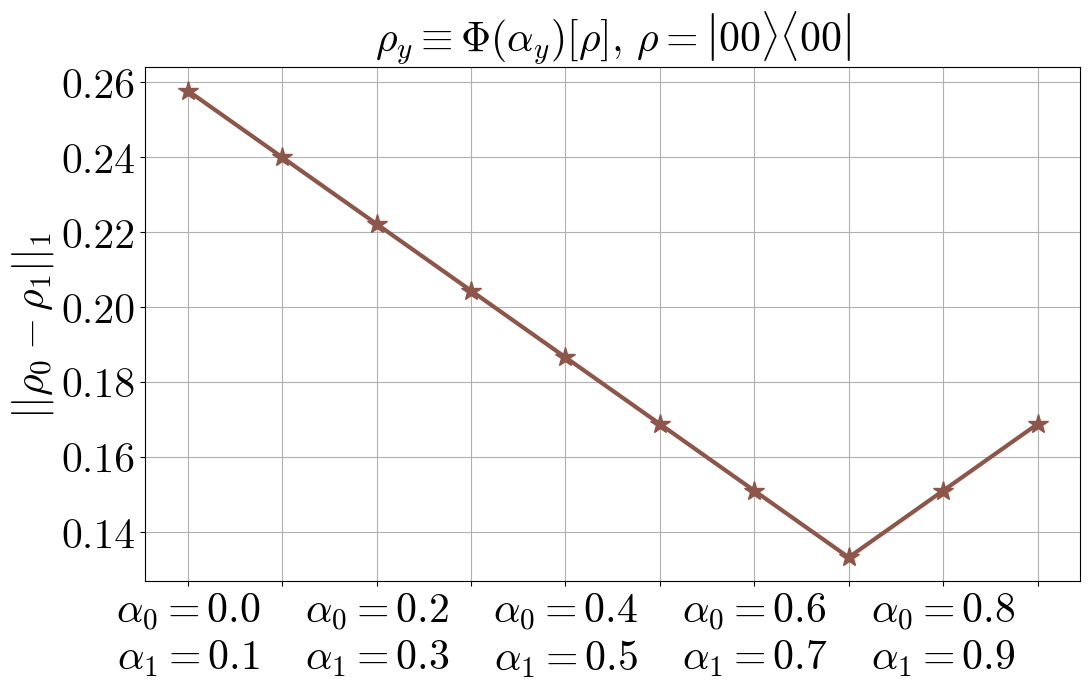

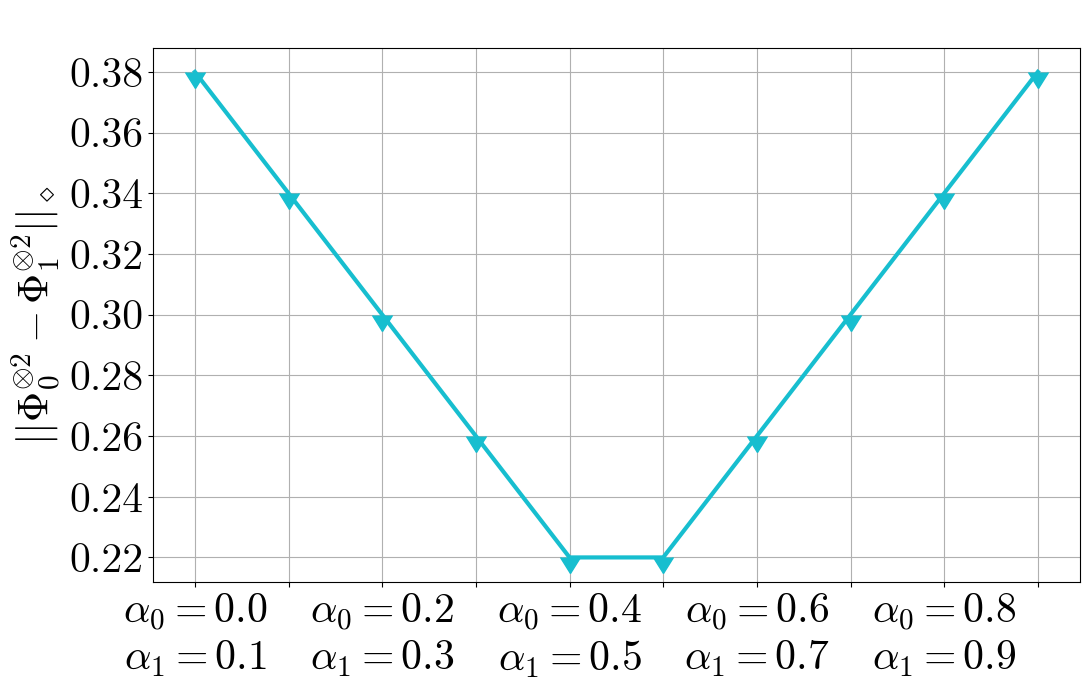

In [22]:
le = len(alphas)-1
fontsize = 30
markersize = 15
markevery = 1
linewidth = 3

sta = 0
fin = 10
ran = 1

plt.figure(figsize=(11, 7))
plt.plot([i for i in range(sta, fin)], array(trdists[sta:fin]), marker="*", markevery=markevery, markersize=markersize, color="tab:brown", linewidth=linewidth)
plt.xticks([i for i in range(sta, le)], [r"$\alpha_0="+str(alphas[i])+"$"+"\n" + r"$\alpha_1="+str(alphas[i+1])+"$" if i%2==0 else None for i in range(sta,le)], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel(r"$||\rho_0 - \rho_1 ||_1$", fontsize=fontsize)
plt.title(r"$\rho_y \equiv \Phi(\alpha_y)[\rho]$, $\rho = \left| 00 \rangle\langle 00 \right|$", fontsize=fontsize)
plt.grid()
plt.tight_layout()
plt.savefig("trdists.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(11, 7))
plt.plot([i for i in range(sta, fin)], array(diams[sta:fin]), marker=11, markevery=markevery, markersize=markersize, color="tab:cyan", linewidth=linewidth)
plt.xticks([i for i in range(sta, le)], [r"$\alpha_0="+str(alphas[i])+"$"+"\n" + r"$\alpha_1="+str(alphas[i+1])+"$" if i%2==0 else None for i in range(sta,le)], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel(r"$||\Phi^{\otimes 2}_0 - \Phi_1^{\otimes 2}||_\diamond$", fontsize=fontsize)
plt.title(r"$\,$", fontsize=fontsize)
plt.grid()
plt.tight_layout()
plt.savefig("diams.pdf", bbox_inches='tight')
plt.show()

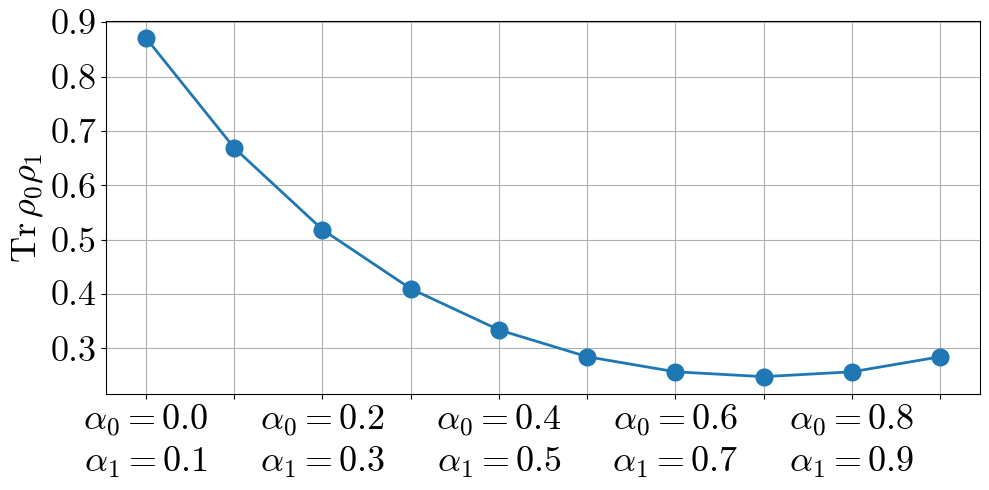

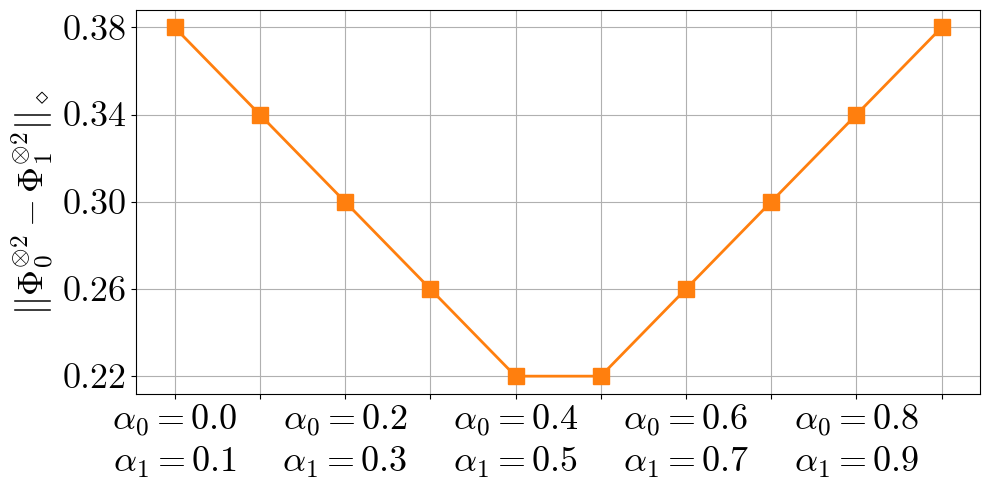

In [9]:
le = len(alphas)-1
fontsize = 26
plt.figure(figsize=(10, 5))
plt.plot([i for i in range(le)], trpords, marker="o", color="C0", markersize=12, linewidth=2)
plt.xticks([i for i in range(le)], [r"$\alpha_0="+str(alphas[i])+"$"+"\n" + r"$\alpha_1="+str(alphas[i+1])+"$" if i%2==0 else None for i in range(le)], fontsize=fontsize)
# plt.xticks([i for i in range(le)], tkz, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel(r"$\mathrm{Tr}\, \rho_0 \rho_1$", fontsize=fontsize)
plt.grid()
plt.tight_layout()
# plt.savefig("trdists.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot([i for i in range(le)], diams, marker="s", color="C1", markersize=12, linewidth=2)
plt.xticks([i for i in range(le)], [r"$\alpha_0="+str(alphas[i])+"$"+"\n" + r"$\alpha_1="+str(alphas[i+1])+"$" if i%2==0 else None for i in range(le)], fontsize=fontsize)
plt.yticks(np.arange(0.22, 0.4, 0.04), fontsize=fontsize)
plt.ylabel(r"$||\Phi^{\otimes 2}_0 - \Phi_1^{\otimes 2}||_\diamond$", fontsize=fontsize)
plt.grid()
plt.tight_layout()
# plt.savefig("diadists.pdf", bbox_inches='tight')
plt.show()

0.0 0.1
0.1 0.2
0.2 0.3
0.3 0.4
0.4 0.5
0.5 0.6
0.6 0.7
0.7 0.8
0.8 0.9
0.9 1.0


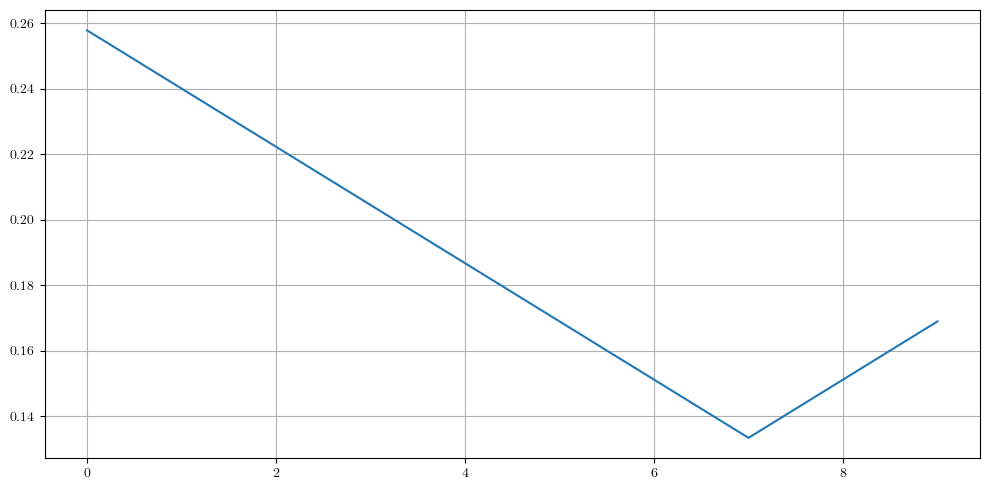

In [10]:
n_runs = 2
d = 2**n_runs
alphas = np.round(np.linspace(0., 1, 11), 2)

dm_in = array([[1/d]*d]*d)
bell_sv = phi_generator(2*n_runs, normalized=False)
bell_dm = np.outer(bell_sv, bell_sv.conj().T)

fids = []
trdists = []
trpords = []
diams = []
for i in range(len(alphas)-1):
    # print(alphas[i], alphas[i+1], end="\r")
    print(alphas[i], alphas[i+1])
    
    # dm1 = array([[1/d]*d]*d)
    # dm2 = array([[1/d]*d]*d)
    dm1 = np.diag([1] + [0]*(d-1))
    dm2 = np.diag([1] + [0]*(d-1))
    for r in range(n_runs):
        dm1 = depolarizing_channel(n_runs, dm1, alphas[i], r)
        dm2 = depolarizing_channel(n_runs, dm2, alphas[i+1], r)
    fid = fidelity(dm1, dm2)
    trd = trace_distance(dm1, dm2)
    ptr = trace(dot(dm1, dm2)).real

    # dm1 = bell_dm / d
    # dm2 = bell_dm / d
    # for r in range(n_runs):
    #     dm1 = depolarizing_channel(2*n_runs, dm1, alphas[i], r)
    #     dm2 = depolarizing_channel(2*n_runs, dm2, alphas[i+1], r)
    # fid = fidelity(dm1, dm2)
    # trd = trace_distance(dm1, dm2)
    # ptr = trace(dot(dm1, dm2)).real

    choi1 = bell_dm
    choi2 = bell_dm
    for r in range(n_runs, 2*n_runs):
        choi1 = depolarizing_channel(2*n_runs, choi1, alphas[i], r)
        choi2 = depolarizing_channel(2*n_runs, choi2, alphas[i+1], r)
    choi1 = Choi(choi1)
    choi2 = Choi(choi2)
    dia = diamond_norm(choi1 - choi2, solver='SCS').real    

    fids.append(fid)
    trdists.append(trd)
    trpords.append(ptr)
    diams.append(dia)
    
pdiams = 0.5 + 0.25*array(diams)
infids = 1 - np.array(fids)

plt.figure(figsize=(10, 5))
plt.plot(trdists, color="C0")
plt.grid()
plt.tight_layout()
plt.show()

# Sequentional

In [11]:
p_sucs_seq_1 = np.array([
[0.562222222, 0.553333333, 0.544444444, 0.535555556, 0.526666667, 0.534585723, 0.53363364, 0.533333333, 0.53363364, 0.534585723],
[0.562222222, 0.553333333, 0.544444444, 0.535555556, 0.526666667, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333],
[0.562222221, 0.553333333, 0.544444443, 0.535555555, 0.526666666, 0.517777777, 0.533333326, 0.533333332, 0.533333317, 0.533333308],
[0.562222221, 0.553333333, 0.544444443, 0.535555555, 0.526666666, 0.517777777, 0.533333326, 0.533333332, 0.533333317, 0.533333308],
[0.562222208, 0.553333321, 0.544444438, 0.53555552, 0.533333331, 0.533333327, 0.533333268, 0.533333309, 0.533333329, 0.533333331],
[0.562222222, 0.553333333, 0.544444444, 0.535555553, 0.536369647, 0.534585722, 0.533633638, 0.533333333, 0.533633627, 0.534585722],
[0.562222222, 0.553333333, 0.544444444, 0.535555556, 0.526666667, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333],
[0.562222222, 0.553333333, 0.544444444, 0.535555555, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333],
[0.562222222, 0.553333333, 0.544444444, 0.535555556, 0.526666667, 0.517777778, 0.533333333, 0.533333329, 0.508888889, 0.533333333],
[0.562222219, 0.553333333, 0.544444444, 0.533333333, 0.533333333, 0.533333326, 0.533333333, 0.533333333, 0.533333333, 0.517777778],
])

p_sucs_seq_2 = np.array([
[0.586658598, 0.573881518, 0.561275853, 0.549001107, 0.537754968, 0.541111096, 0.545555535, 0.549999975, 0.554444415, 0.553614648],
[0.59333333, 0.579999997, 0.566666664, 0.553333331, 0.539999999, 0.541246873, 0.545723296, 0.550625998, 0.556378783, 0.563333458],
[0.593346651, 0.580152158, 0.567232858, 0.555051627, 0.546666655, 0.541111105, 0.545555549, 0.549999994, 0.554444439, 0.558888884],
[0.581033673, 0.568569497, 0.55734174, 0.550909036, 0.549999999, 0.549999967, 0.55065994, 0.553351633, 0.555683216, 0.565916136],
[0.593333330, 0.579999998, 0.566666665, 0.553333332, 0.539999999, 0.541111101, 0.545555543, 0.549999985, 0.554444428, 0.558888827],
[0.593333, 0.580000, 0.566667, 0.553333, 0.540000, 0.543449, 0.549763, 0.557349, 0.566587, 0.577667],
[0.593333, 0.580000, 0.566667, 0.553333, 0.540000, 0.550000, 0.553873, 0.560481, 0.567369, 0.574397],
[0.592222221, 0.576666666, 0.56111111, 0.545555555, 0.53, 0.547754405, 0.546004328, 0.550000001, 0.569999979, 0.589999965],
[0.57924513, 0.568524764, 0.557341737, 0.547974909, 0.54177838, 0.55, 0.552442389, 0.556903535, 0.561731674, 0.566689964],
[0.581979, 0.571215, 0.562067, 0.554373, 0.550000, 0.550000, 0.550000, 0.553658, 0.559872, 0.566643],
])

p_sucs_seq_3 = np.array([
[0.593328752, 0.579996868, 0.566664521, 0.553332197, 0.551713206, 0.552940829, 0.561497703, 0.570144629, 0.579495161, 0.590252051],
[0.590904190, 0.580895799, 0.569191692, 0.558162806, 0.551091336, 0.549502151, 0.552063786, 0.558426179, 0.565842655, 0.573183534],
[0.593331103, 0.579998911, 0.566666008, 0.558162032, 0.549999702, 0.554999880, 0.564999828, 0.574999773, 0.571613756, 0.578846896],
[0.591396819, 0.578157513, 0.570872499, 0.560769917, 0.551496104, 0.553332836, 0.554556916, 0.562008810, 0.569139840, 0.575491342],
[0.593331999, 0.579999149, 0.566666127, 0.553333057, 0.549999495, 0.553333304, 0.559999959, 0.566666590, 0.573333160, 0.589999086] 
])

p_sucs_seq_4 = np.array([
[0.591925252, 0.583683583, 0.574996312, 0.564997724, 0.554998432, 0.551721074, 0.559881073, 0.568456037, 0.5774081, 0.586716879],
[0.593112522, 0.579960739, 0.572027236, 0.561963654, 0.554225626, 0.549612537, 0.555887571, 0.563525704, 0.569935801, 0.577886123],
[0.594198745, 0.583329166, 0.572476904, 0.561915318, 0.553332742, 0.550229593, 0.55650907, 0.56422776, 0.572220561, 0.580889619],
[0.592749187, 0.583114755, 0.572781869, 0.562647095, 0.553010345, 0.550694976, 0.556824717, 0.564324592, 0.572349722, 0.581070759],
[0.592762322, 0.581306639, 0.571386699, 0.561311415, 0.55304761, 0.549660136, 0.556102409, 0.563289861, 0.570913566, 0.579229868],
[0.593075604, 0.583641165, 0.573268067, 0.563054867, 0.55379766, 0.551440536, 0.559077657, 0.567650717, 0.57642287, 0.585384351],
[0.59308108, 0.581631287, 0.572066861, 0.56225918, 0.553371119, 0.550907274, 0.557400368, 0.565105343, 0.573215626, 0.581513544],
[0.592948172, 0.583671498, 0.573324582, 0.563334926, 0.553653813, 0.551714039, 0.55889357, 0.567008054, 0.574623412, 0.584307657],
[0.59253898, 0.580012896, 0.573660394, 0.563524238, 0.553761279, 0.551881467, 0.556709993, 0.564409004, 0.572574191, 0.581308574],
[0.593022126, 0.580640001,0.572553621,0.56274111,0.553339554,0.553269009,0.562115839,0.571301737,0.580614276,0.590053462],
])

p_sucs_seq_5 = np.array([
[0.59325307, 0.581303802, 0.572074381, 0.562174118, 0.553166381, 0.551435651, 0.559416669, 0.567932856, 0.576713435, 0.585773199],
[0.593555819, 0.582395675, 0.571875864, 0.562046322, 0.5529044, 0.552018898, 0.562458198, 0.568512403, 0.577397836, 0.585672513],
[0.593298437, 0.582310411, 0.572036236, 0.56214574, 0.553328667, 0.55169067, 0.559464865, 0.567963063, 0.576598445, 0.58599076],
[0.593252122, 0.582557015, 0.571857834, 0.56255403, 0.55343286, 0.552746335, 0.561300041, 0.570343612, 0.579526796, 0.588844561],
[0.593491329, 0.582343065, 0.571829187, 0.562301841, 0.553260628, 0.551674289, 0.559678871, 0.567963227, 0.576687662, 0.5851348]
])

p_sucs_seq_8 = np.array([
[0.594884116, 0.584753778, 0.57470391, 0.564754707, 0.554879188, 0.554169014, 0.563754296, 0.573318556, 0.582962612, 0.592669631],
[0.594828004, 0.584658901, 0.574638356, 0.56466932, 0.553332181, 0.554282656, 0.563767951, 0.573436793, 0.583162594, 0.592802347],
[0.594836662, 0.584666366, 0.574605921, 0.564749709, 0.554853407, 0.554245512, 0.563726497, 0.573378756, 0.583105663, 0.592912809],
[0.594847812, 0.584676156, 0.574597259, 0.564648586, 0.554812139, 0.554320156, 0.563738651, 0.57341029, 0.583126583, 0.592886843, ],
[0.594854544, 0.584672277, 0.574703723, 0.564733163, 0.554839797, 0.554197949, 0.563761545, 0.573387412, 0.583119786, 0.592930711],
[0.594860508, 0.584711829, 0.574694528, 0.564711473, 0.554809819, 0.554317024, 0.563811824, 0.573471863, 0.583184067, 0.592826188],
[0.593022126, 0.580640001, 0.572553621, 0.56274111, 0.553339554, 0.553269009, 0.562115839, 0.571301737, 0.580614276, 0.590053462],
[0.594867537, 0.584725299, 0.574662609, 0.564675665, 0.554797097, 0.554322332, 0.563839705, 0.573503968, 0.583233262, 0.592756726],
[0.594827796, 0.584633333, 0.57454725, 0.564761162, 0.554858966, 0.554397163, 0.563962319, 0.573254346, 0.582944133, 0.592706806],
[0.594866776, 0.584792868, 0.574734505, 0.564740316, 0.554851202, 0.554262483, 0.563780468, 0.573197641, 0.582855729, 0.592419583],
])

p_sucs_seq_14 = np.array([
[0.594999999, 0.584999999, 0.574999999, 0.564999999, 0.554999999, 0.554997600, 0.564996200, 0.574995000, 0.584994000, 0.594993200],
[0.594999866, 0.584999867, 0.574999835, 0.564999878, 0.554999908, 0.554998953, 0.564998202, 0.574997666, 0.584997221, 0.594996859],
[0.594999879, 0.584999910, 0.574999894, 0.564999914, 0.554999934, 0.554997769, 0.564996333, 0.574995356, 0.584994530, 0.594993834],
# [],
# [],
# [],
# [],
# [],
# [],
# [],
])


p_sucs_seq_1_means = np.mean(p_sucs_seq_1, axis=0)
p_sucs_seq_2_means = np.mean(p_sucs_seq_2, axis=0)
p_sucs_seq_3_means = np.mean(p_sucs_seq_3, axis=0)
p_sucs_seq_4_means = np.mean(p_sucs_seq_4, axis=0)
p_sucs_seq_5_means = np.mean(p_sucs_seq_5, axis=0)
p_sucs_seq_8_means = np.mean(p_sucs_seq_8, axis=0)
p_sucs_seq_14_means = np.mean(p_sucs_seq_14, axis=0)

p_sucs_seq_1_stds = np.std(p_sucs_seq_1, axis=0)
p_sucs_seq_2_stds = np.std(p_sucs_seq_2, axis=0)
p_sucs_seq_3_stds = np.std(p_sucs_seq_3, axis=0)
p_sucs_seq_4_stds = np.std(p_sucs_seq_4, axis=0)
p_sucs_seq_5_stds = np.std(p_sucs_seq_5, axis=0)
p_sucs_seq_8_stds = np.std(p_sucs_seq_8, axis=0)
p_sucs_seq_14_stds = np.std(p_sucs_seq_14, axis=0)

p_sucs_seq_1_bound_u = []
p_sucs_seq_2_bound_u = []
p_sucs_seq_4_bound_u = []
p_sucs_seq_8_bound_u = []
p_sucs_seq_14_bound_u = []
for i in range(len(alphas)-1):
    up1 = p_sucs_seq_1_means[i] + p_sucs_seq_1_stds[i]
    up2 = p_sucs_seq_2_means[i] + p_sucs_seq_2_stds[i]
    up4 = p_sucs_seq_4_means[i] + p_sucs_seq_4_stds[i]
    up8 = p_sucs_seq_8_means[i] + p_sucs_seq_8_stds[i]
    up14 = p_sucs_seq_14_means[i] - p_sucs_seq_14_stds[i]
    if up1 < pdiams[i]:
        p_sucs_seq_1_bound_u.append(up1)
    else:
        p_sucs_seq_1_bound_u.append(pdiams[i])
    if up2 < pdiams[i]:
        p_sucs_seq_2_bound_u.append(up2)
    else:
        p_sucs_seq_2_bound_u.append(pdiams[i])
    if up4 < pdiams[i]:
        p_sucs_seq_4_bound_u.append(up4)
    else:
        p_sucs_4_bound_u.append(pdiams[i])
    if up8 < pdiams[i]:
        p_sucs_seq_8_bound_u.append(up8)
    else:
        p_sucs_seq_8_bound_u.append(pdiams[i])
    if up14 < pdiams[i]:
        p_sucs_seq_14_bound_u.append(up14)
    else:
        p_sucs_seq_14_bound_u.append(pdiams[i])
        
p_sucs_seq_1_bound_l = []
p_sucs_seq_2_bound_l = []
p_sucs_seq_4_bound_l = []
p_sucs_seq_8_bound_l = []
p_sucs_seq_14_bound_l = []
for i in range(len(alphas)-1):
    do1 = p_sucs_seq_1_means[i] - p_sucs_seq_1_stds[i]
    do2 = p_sucs_seq_2_means[i] - p_sucs_seq_2_stds[i]
    do4 = p_sucs_seq_4_means[i] - p_sucs_seq_4_stds[i]
    do8 = p_sucs_seq_8_means[i] - p_sucs_seq_8_stds[i]
    do14 = p_sucs_seq_14_means[i] - p_sucs_seq_14_stds[i]
    if do1 > 0.5:
        p_sucs_seq_1_bound_l.append(do1)
    else:
        p_sucs_seq_1_bound_l.append(0.5)
    if do2 > 0.5:
        p_sucs_seq_2_bound_l.append(do2)
    else:
        p_sucs_seq_2_bound_l.append(0.5)
    if do4 > 0.5:
        p_sucs_seq_4_bound_l.append(do4)
    else:
        p_sucs_seq_4_bound_l.append(0.5)
    if do8 > 0.5:
        p_sucs_seq_8_bound_l.append(do8)
    else:
        p_sucs_seq_8_bound_l.append(0.5)
    if do14 > 0.5:
        p_sucs_seq_14_bound_l.append(do14)
    else:
        p_sucs_seq_14_bound_l.append(0.5)     

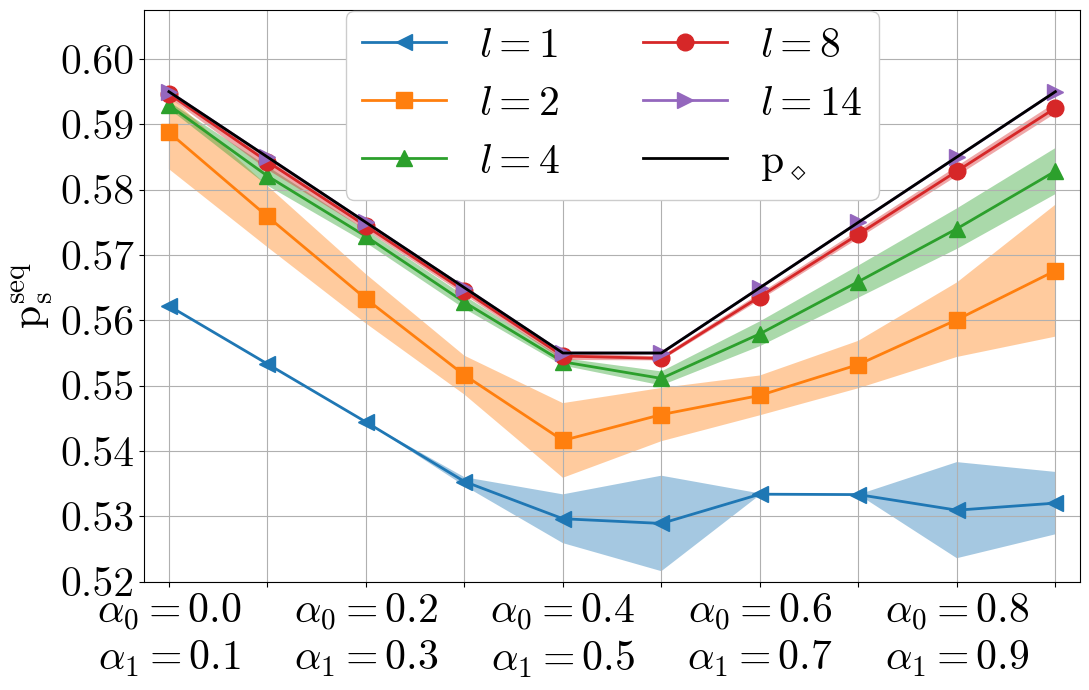

In [12]:
alphas = np.round(np.linspace(0, 1, 11), 1)

fontsize = 30
markersize = 12
linewidth = 2
plt.figure(figsize=(11, 7))
x_axis = np.arange(len(alphas)-1)
plt.plot(x_axis, p_sucs_seq_1_means, marker="<", markersize=markersize, label=r"$l=1$", linewidth=linewidth)
plt.plot(x_axis, p_sucs_seq_2_means, marker="s", markersize=markersize, label=r"$l=2$", linewidth=linewidth)
plt.plot(x_axis, p_sucs_seq_4_means, marker="^", markersize=markersize, label=r"$l=4$", linewidth=linewidth)
plt.plot(x_axis, p_sucs_seq_8_means, marker="o", markersize=markersize, label=r"$l=8$", linewidth=linewidth)
plt.plot(x_axis, p_sucs_seq_14_means, marker=">", markersize=markersize, label=r"$l=14$", linewidth=linewidth)
plt.fill_between(x_axis, p_sucs_seq_1_bound_l, p_sucs_seq_1_bound_u, alpha=0.4)
plt.fill_between(x_axis, p_sucs_seq_2_bound_l, p_sucs_seq_2_bound_u, alpha=0.4)
plt.fill_between(x_axis, p_sucs_seq_4_bound_l, p_sucs_seq_4_bound_u, alpha=0.4)
plt.fill_between(x_axis, p_sucs_seq_8_bound_l, p_sucs_seq_8_bound_u, alpha=0.4)
plt.fill_between(x_axis, p_sucs_seq_14_bound_l, p_sucs_seq_14_bound_u, alpha=0.4)
plt.plot(x_axis, pdiams, marker=None, label=r"$\mathrm{p}_\diamond$", color="black", linewidth=linewidth)
plt.xticks([i for i in range(le)], [r"$\alpha_0="+str(alphas[i])+"$"+"\n" + r"$\alpha_1="+str(alphas[i+1])+"$" if i%2==0 else None for i in range(le)], fontsize=fontsize)
plt.yticks(np.arange(0.52, 0.64, 0.01), fontsize=fontsize)
plt.xlim(-0.25, 9.25)
plt.ylim(0.52, 0.6075)
plt.ylabel(r"$\mathrm{p_s^{seq}}$", fontsize=fontsize)
plt.legend(loc="upper center", fontsize=fontsize, ncol=2, bbox_to_anchor=(0.5, 1.035), framealpha=1)#, bbox_to_anchor=(0.5, 0.675)
plt.grid()
plt.tight_layout()
# plt.savefig("psuc-seq-l(2,14).pdf", bbox_inches='tight')
plt.show()

### Correlations

In [13]:
corrs_seq_tp = [np.corrcoef(p_sucs_seq_1_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_seq_2_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_seq_3_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_seq_4_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_seq_5_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_seq_8_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_seq_14_means, np.array(trpords))[0][1]]

corrs_seq_dd = [np.corrcoef(p_sucs_seq_1_means, diams)[0][1],
                np.corrcoef(p_sucs_seq_2_means, diams)[0][1],
                np.corrcoef(p_sucs_seq_3_means, diams)[0][1],
                np.corrcoef(p_sucs_seq_4_means, diams)[0][1],
                np.corrcoef(p_sucs_seq_5_means, diams)[0][1],
                np.corrcoef(p_sucs_seq_8_means, diams)[0][1],
                np.corrcoef(p_sucs_seq_14_means, diams)[0][1]]

corrs_seq_td = [np.corrcoef(p_sucs_seq_1_means, trdists)[0][1],
                np.corrcoef(p_sucs_seq_2_means, trdists)[0][1],
                np.corrcoef(p_sucs_seq_3_means, trdists)[0][1],
                np.corrcoef(p_sucs_seq_4_means, trdists)[0][1],
                np.corrcoef(p_sucs_seq_5_means, trdists)[0][1],
                np.corrcoef(p_sucs_seq_8_means, trdists)[0][1],
                np.corrcoef(p_sucs_seq_14_means, trdists)[0][1]]

corrs_seq_fd = [np.corrcoef(p_sucs_seq_1_means, fids)[0][1],
                np.corrcoef(p_sucs_seq_2_means, fids)[0][1],
                np.corrcoef(p_sucs_seq_3_means, fids)[0][1],
                np.corrcoef(p_sucs_seq_4_means, fids)[0][1],
                np.corrcoef(p_sucs_seq_5_means, fids)[0][1],
                np.corrcoef(p_sucs_seq_8_means, fids)[0][1],
                np.corrcoef(p_sucs_seq_14_means, fids)[0][1]]

corrs_seq_if = [np.corrcoef(p_sucs_seq_1_means, infids)[0][1],
                np.corrcoef(p_sucs_seq_2_means, infids)[0][1],
                np.corrcoef(p_sucs_seq_3_means, infids)[0][1],
                np.corrcoef(p_sucs_seq_4_means, infids)[0][1],
                np.corrcoef(p_sucs_seq_5_means, infids)[0][1],
                np.corrcoef(p_sucs_seq_8_means, infids)[0][1],
                np.corrcoef(p_sucs_seq_14_means, infids)[0][1]]

In [14]:
x_seq = array([1, 2, 3, 4, 5, 8, 14])

def fitting_func_tp(x, a):
    return x**(-1/a)
popt_mean_tp, pcov_mean_tp = curve_fit(fitting_func_tp, x_seq, corrs_seq_tp, bounds=(0, [10]), method=None)#
corrs_seq_tp_fit = fitting_func_tp(x_seq, *popt_mean_tp)

def fitting_func_td(x, a):
    return x**(-1/a)
popt_mean_td, pcov_mean_tp = curve_fit(fitting_func_td, x_seq, corrs_seq_td, bounds=(0, [10]), method=None)#
corrs_seq_td_fit = fitting_func_td(x_seq, *popt_mean_td)

def fitting_func_dd(x, a):
    return 1 - np.exp(-x*a)
popt_mean_dd, pcov_mean_dd = curve_fit(fitting_func_dd, x_seq, corrs_seq_dd, bounds=(-10, [10]), method=None)#
corrs_seq_dd_fit = fitting_func_dd(x_seq, *popt_mean_dd)

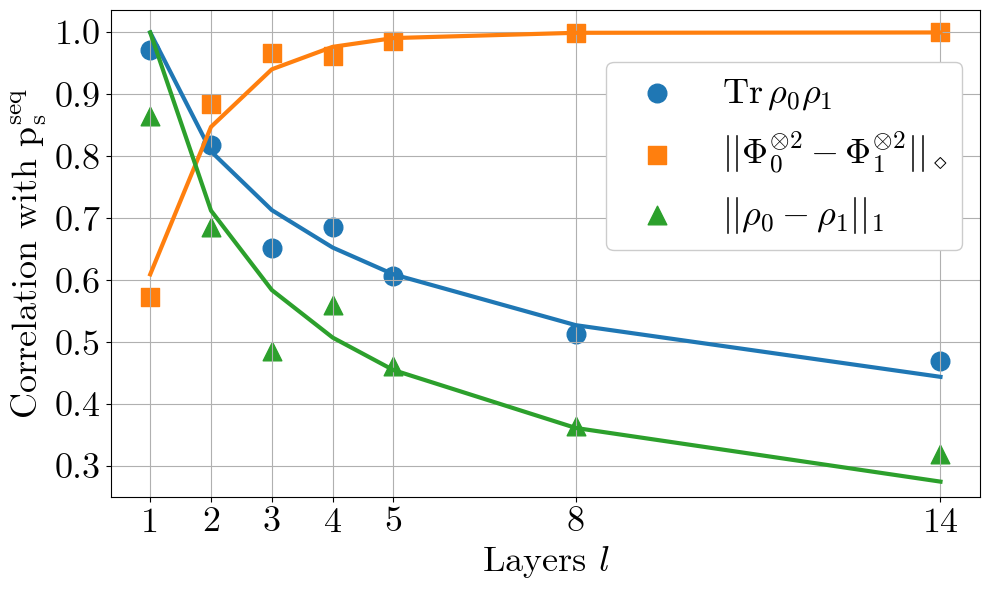

In [15]:
fontsize = 26
markersize = 180
linewidth = 3
plt.figure(figsize=(10, 6))
plt.scatter(x_seq, corrs_seq_tp, marker="o", label=r"$\mathrm{Tr}\, \rho_0 \rho_1$", color="C0", s=markersize)
plt.scatter(x_seq, corrs_seq_dd, marker="s", label=r"$||\Phi^{\otimes 2}_0 - \Phi_1^{\otimes 2}||_\diamond$", color="C1", s=markersize)
plt.scatter(x_seq, corrs_seq_td, marker="^", label=r"$||\rho_0 - \rho_1||_1$", color="C2", s=markersize)
plt.plot(x_seq, corrs_seq_tp_fit, color="C0", linewidth=linewidth)
plt.plot(x_seq, corrs_seq_dd_fit, color="C1", linewidth=linewidth)
plt.plot(x_seq, corrs_seq_td_fit, color="C2", linewidth=linewidth)
# plt.plot(x_axis, corrs_td, marker="<", markersize=8, label="Trace distance", color="C3")
# plt.plot(x_axis, corrs_if, marker=">", markersize=8, label="Infidelity", color="C4")
# plt.plot(x_axis, tds, marker=None, label=r"Trace distance (adjusted)", color="purple", linewidth=0.5)
plt.xticks(x_seq, x_seq, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"Layers $l$", fontsize=fontsize)
plt.ylabel(r"Correlation with $\mathrm{p_s^{seq}}$", fontsize=fontsize)
plt.ylim(ymin=0.25)
# plt.title("Sequential", fontsize=fontsize)
plt.legend(framealpha=1, fontsize=fontsize, bbox_to_anchor=(1., 0.7), loc=5)
plt.grid()
plt.tight_layout()
plt.savefig("correlations-seq.pdf", bbox_inches='tight')
plt.show()

# Parallel

In [16]:
p_sucs_par_1 = np.array([
[0.562222221, 0.553333333, 0.544444443, 0.535555555, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333],
[0.562222221, 0.553333333, 0.544444444, 0.535555554, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333],
[0.562222222, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333],
[0.562222222, 0.553333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333],
[0.53333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333333, 0.533333331, 0.533333333]
])

p_sucs_par_2 = np.array([
[0.593333332, 0.579999999, 0.566666666, 0.553333332, 0.539999999, 0.540984948, 0.542765162, 0.54516605, 0.547960243, 0.551309532],
[0.562222222, 0.553333333, 0.544444444, 0.535555555, 0.526666667, 0.536554994, 0.538395942, 0.540236892, 0.542077841, 0.54391879],
[0.580197891, 0.568524698, 0.556949154, 0.545608009, 0.535296278, 0.535659057, 0.537828067, 0.540236892, 0.542789813, 0.545436616],
[0.562222216, 0.553333328, 0.54444444, 0.535555552, 0.526666664, 0.54042698, 0.540152533, 0.540236891, 0.540802908, 0.542459051],
[0.593333331, 0.579999998, 0.566666665, 0.553333332, 0.539999999, 0.541111111, 0.545555555, 0.549999999, 0.554444444, 0.558888888],
[0.576666665, 0.563333332, 0.549999999, 0.536666666, 0.523333334, 0.536554984, 0.538395933, 0.540236882, 0.54207783, 0.543918779],
[0.571890552, 0.562058303, 0.552891756, 0.544685573, 0.538261152, 0.538870452, 0.540727587, 0.543301261, 0.546528123, 0.550540095],
[0.576666662, 0.56333333, 0.549999998, 0.536666666, 0.523333334, 0.535836971, 0.537458561, 0.539227256, 0.541144496, 0.543206856],
[0.562222222, 0.553333333, 0.544444444, 0.535555555, 0.526666667, 0.533333331, 0.533333331, 0.533333331, 0.53333333, 0.53333333],
[0.580197891, 0.568524697, 0.556949151, 0.545608009, 0.535296278, 0.533333328, 0.533333327, 0.533333327, 0.533333327, 0.533333326]
])

p_sucs_par_3 = np.array([
[0.587294531, 0.573899718, 0.562464609, 0.552544698, 0.543485354, 0.541802281, 0.546264270, 0.551594107, 0.558166392, 0.567089977],
[0.593333306, 0.579999977, 0.566666648, 0.553333319, 0.539999990, 0.543531250, 0.549637078, 0.556765285, 0.565232755, 0.575347065],
[0.593333326, 0.579999994, 0.566666662, 0.553333329, 0.539999997, 0.541111105, 0.545555547, 0.549999989, 0.554444432, 0.558888874],
[0.593333316, 0.579999987, 0.566666656, 0.553333325, 0.539999994, 0.541111100, 0.545555542, 0.549999983, 0.554444425, 0.558888868],
[0.593333306, 0.579999975, 0.566666645, 0.553333321, 0.546666665, 0.545555545, 0.548000108, 0.553456362, 0.559297558, 0.565926846],
[0.593333324, 0.579999993, 0.566666661, 0.553333329, 0.539999998, 0.544507353, 0.548911156, 0.554098500, 0.560004350, 0.566793016],
[0.593333330, 0.579999998, 0.566666665, 0.553333332, 0.539999999, 0.510000000, 0.530000000, 0.550000000, 0.569999999, 0.589999999],
[0.593333327, 0.579999995, 0.566666662, 0.553333330, 0.539999997, 0.541111106, 0.545555550, 0.550459038, 0.555932836, 0.562172844],
[0.586467533, 0.573206699, 0.562568691, 0.552503298, 0.549999999, 0.550955840, 0.555492687, 0.561212414, 0.568306823, 0.577499580],
[0.593333333, 0.579999998, 0.566666665, 0.553333332, 0.539999999, 0.549999984, 0.550332846, 0.553653476, 0.558635812, 0.566144525],
])

p_sucs_par_4 = np.array([
[0.593333247, 0.579999926, 0.566666607, 0.553333287, 0.546666616, 0.551945834, 0.557838401, 0.563647958, 0.571698316, 0.583292516],
[0.593333332, 0.579999999, 0.566666666, 0.553333332, 0.539999999, 0.540984948, 0.542765162, 0.54516605, 0.547960243, 0.551309532],
[0.593333237, 0.579999916, 0.566666595, 0.55333328, 0.53999997, 0.547183139, 0.553562571, 0.56085168, 0.569415029, 0.580419449],
[0.593333317, 0.579999986, 0.566666656, 0.553333325, 0.539999994, 0.547224886, 0.553720603, 0.560931788, 0.568850053, 0.574312231],
[0.593333298, 0.579999972, 0.566666644, 0.553333315, 0.539999987, 0.548888873, 0.557777756, 0.566666639, 0.575555522, 0.584444406],
[0.593333109, 0.579999823, 0.566666545, 0.553333262, 0.54668171, 0.548888881, 0.557777769, 0.566666656, 0.575555543, 0.584444431],
[0.593333217, 0.579999901, 0.566666585, 0.553333271, 0.539999962, 0.549999925, 0.551122502, 0.557942299, 0.565393644, 0.574181104],
[0.593333282, 0.579999956, 0.56666663, 0.553333304, 0.539999979, 0.548971978, 0.554155432, 0.558118589, 0.5654142, 0.574238295],
[0.562222222, 0.553333333, 0.544444444, 0.535555555, 0.526666667, 0.536554994, 0.538395942, 0.540236892, 0.542077841, 0.54391879],
[0.576666665, 0.563333332, 0.549999999, 0.536666666, 0.523333334, 0.536554984, 0.538395933, 0.540236882, 0.54207783, 0.543918779],
])

p_sucs_par_5 = [
[0.591323841, 0.578258033, 0.566041002, 0.556481868, 0.553333274, 0.546294008, 0.551700441, 0.557788835, 0.565384798, 0.574303815],
[0.593333229, 0.579999913, 0.566666598, 0.553333292, 0.552051610, 0.551733065, 0.558276939, 0.565635231, 0.569999961, 0.589999936],
[0.590797185, 0.583333262, 0.572222149, 0.561111049, 0.549999953, 0.546538202, 0.551022457, 0.556722575, 0.563530015, 0.571744066],
[0.593333362, 0.580200782, 0.570367645, 0.559150150, 0.548810024, 0.549471573, 0.557904872, 0.566607209, 0.575467283, 0.584590427],
[0.593333267, 0.579999947, 0.56666665, 0.5611110940, 0.549999988, 0.546667843, 0.551696367, 0.557747904, 0.564910017, 0.573178982],
[0.591353395, 0.578355819, 0.566190888, 0.555607685, 0.548463604, 0.549126643, 0.556821267, 0.549999993, 0.569999989, 0.589999986],
[0.591677073, 0.578670129, 0.565910898, 0.556166018, 0.553333327, 0.551330186, 0.557798551, 0.565575655, 0.574965394, 0.589999910],
[0.593333223, 0.580152046, 0.567232672, 0.560765432, 0.549816853, 0.552107302, 0.558818879, 0.549999996, 0.569999992, 0.589999990],
[0.591635753, 0.578531393, 0.565606687, 0.561877452, 0.552408478, 0.553333288, 0.557353530, 0.566066750, 0.575047027, 0.584626239],
[0.593333309, 0.579999980, 0.566666651, 0.553333321, 0.539999992, 0.553333261, 0.554596305, 0.562348268, 0.570345699, 0.578954328],
]

p_sucs_par_8 = np.array([
[0.593321065, 0.579988961, 0.569945496, 0.559199682, 0.551817127, 0.550626218, 0.557978456, 0.565814864, 0.574011988, 0.581690741],
[0.593324874, 0.579992693, 0.570079886, 0.559283721, 0.551817656, 0.550639617, 0.557234945, 0.565154486, 0.573561998, 0.582619718],
[0.593321761, 0.57999047, 0.570366692, 0.559490403, 0.551771608, 0.550529615, 0.557658611, 0.565564846, 0.574004771, 0.583162466],
[0.593333282, 0.579999956, 0.56666663, 0.553333304, 0.539999979, 0.548971978, 0.554155432, 0.558118589, 0.5654142, 0.574238295],
[0.593318912, 0.579987576, 0.56665797, 0.559312597, 0.551455747, 0.550774594, 0.55772761, 0.565463076, 0.573654873, 0.58246377],
[0.593321846, 0.579994027, 0.570604843, 0.559487021, 0.55184358, 0.550535619, 0.55786114, 0.5659799, 0.574299253, 0.583437612],
[0.593328915, 0.579996261, 0.570026961, 0.559106944, 0.551759823, 0.550642761, 0.557589619, 0.565142298, 0.573366281, 0.582005613],
[0.593309896, 0.579981603, 0.566657907, 0.559303057, 0.551790014, 0.550415984, 0.557756212, 0.565845372, 0.574311293, 0.583357886],
[0.593331082, 0.579998101, 0.56666542, 0.55943157, 0.551754906, 0.550636438, 0.557958318, 0.565834785, 0.574217672, 0.583235873],
[0.59332652, 0.579994165, 0.570293811, 0.559333812, 0.551815313, 0.550686656, 0.558121707, 0.565984808, 0.573977328, 0.58276928]
])

p_sucs_par_14 = [
[0.593333323, 0.579999994, 0.566666665, 0.561087614, 0.553308376, 0.553980244, 0.563217966, 0.572694208, 0.58227793, 0.592085276], #???
[0.593333061, 0.579999759, 0.566666481, 0.5598946, 0.552388108, 0.551299836, 0.558710304, 0.566831528, 0.575356585, 0.584510247], #???
[0.594429649, 0.583319272, 0.57220594, 0.561095877, 0.553311775, 0.554009889, 0.563331737, 0.572883683, 0.582538554, 0.592384249],
[0.594433742, 0.583312948, 0.572197524, 0.56108994, 0.553311064, 0.554087578, 0.563286204, 0.572831096, 0.582461006, 0.592239493],
[0.594436734, 0.583318969, 0.572206345, 0.561096792, 0.553310724, 0.554030552, 0.563311497, 0.572827254, 0.582480726, 0.591870802],
[0.593333325, 0.579999993, 0.566666661, 0.553333331, 0.553317387, 0.554107720, 0.563388780, 0.572867367, 0.582203241, 0.591962733],
[0.594438250, 0.583323899, 0.572210723, 0.561099890, 0.553320138, 0.554089709, 0.563466237, 0.572987192, 0.582582584, 0.591677622],
[0.593332736, 0.579999512, 0.571073401, 0.560041458, 0.552358383, 0.551225143, 0.558721177, 0.566775326, 0.575237942, 0.584421993],
[0.593333314, 0.579999989, 0.566666658, 0.553333329, 0.553319106, 0.553906101, 0.563044115, 0.572495204, 0.582053458, 0.591775972],
[0.594439102, 0.583321634, 0.572206981, 0.561095468, 0.553312533, 0.554108151, 0.563496793, 0.573047378, 0.582677517, 0.592363029],
]

p_sucs_par_1_means = np.mean(p_sucs_par_1, axis=0)
p_sucs_par_2_means = np.mean(p_sucs_par_2, axis=0)
p_sucs_par_3_means = np.mean(p_sucs_par_3, axis=0)
p_sucs_par_4_means = np.mean(p_sucs_par_4, axis=0)
p_sucs_par_5_means = np.mean(p_sucs_par_5, axis=0)
p_sucs_par_8_means = np.mean(p_sucs_par_8, axis=0)
p_sucs_par_14_means = np.mean(p_sucs_par_14, axis=0)

p_sucs_par_1_stds = np.std(p_sucs_par_1, axis=0)
p_sucs_par_2_stds = np.std(p_sucs_par_2, axis=0)
p_sucs_par_3_stds = np.std(p_sucs_par_3, axis=0)
p_sucs_par_4_stds = np.std(p_sucs_par_4, axis=0)
p_sucs_par_5_stds = np.std(p_sucs_par_5, axis=0)
p_sucs_par_8_stds = np.std(p_sucs_par_8, axis=0)
p_sucs_par_14_stds = np.std(p_sucs_par_14, axis=0)

p_sucs_par_1_bound_u = []
p_sucs_par_2_bound_u = []
p_sucs_par_3_bound_u = []
p_sucs_par_4_bound_u = []
p_sucs_par_5_bound_u = []
p_sucs_par_8_bound_u = []
p_sucs_par_14_bound_u = []
for i in range(len(alphas)-1):
    up1 = p_sucs_par_1_means[i] + p_sucs_par_1_stds[i]
    up2 = p_sucs_par_2_means[i] + p_sucs_par_2_stds[i]
    up3 = p_sucs_par_3_means[i] + p_sucs_par_3_stds[i]
    up4 = p_sucs_par_4_means[i] + p_sucs_par_4_stds[i]
    up5 = p_sucs_par_5_means[i] + p_sucs_par_5_stds[i]
    up8 = p_sucs_par_8_means[i] + p_sucs_par_8_stds[i]
    up14 = p_sucs_par_14_means[i] + p_sucs_par_14_stds[i]
    
    if up1 < pdiams[i]: p_sucs_par_1_bound_u.append(up1)
    else: p_sucs_par_1_bound_u.append(pdiams[i])
    
    if up2 < pdiams[i]: p_sucs_par_2_bound_u.append(up2)
    else: p_sucs_par_2_bound_u.append(pdiams[i])
    
    if up3 < pdiams[i]: p_sucs_par_3_bound_u.append(up3)
    else: p_sucs_par_3_bound_u.append(pdiams[i])
    
    if up4 < pdiams[i]: p_sucs_par_4_bound_u.append(up4)
    else: p_sucs_par_4_bound_u.append(pdiams[i])
    
    if up5 < pdiams[i]: p_sucs_par_5_bound_u.append(up5)
    else: p_sucs_par_5_bound_u.append(pdiams[i])
    
    if up8 < pdiams[i]: p_sucs_par_8_bound_u.append(up8)
    else: p_sucs_par_8_bound_u.append(pdiams[i])
    
    if up14 < pdiams[i]: p_sucs_par_14_bound_u.append(up14)
    else: p_sucs_par_14_bound_u.append(pdiams[i])
        
p_sucs_par_1_bound_l = []
p_sucs_par_2_bound_l = []
p_sucs_par_3_bound_l = []
p_sucs_par_4_bound_l = []
p_sucs_par_5_bound_l = []
p_sucs_par_8_bound_l = []
p_sucs_par_14_bound_l = []
for i in range(len(alphas)-1):
    do1 = p_sucs_par_1_means[i] - p_sucs_par_1_stds[i]
    do2 = p_sucs_par_2_means[i] - p_sucs_par_2_stds[i]
    do3 = p_sucs_par_3_means[i] - p_sucs_par_3_stds[i]
    do4 = p_sucs_par_4_means[i] - p_sucs_par_4_stds[i]
    do5 = p_sucs_par_5_means[i] - p_sucs_par_5_stds[i]
    do8 = p_sucs_par_8_means[i] - p_sucs_par_8_stds[i]
    do14 = p_sucs_par_14_means[i] - p_sucs_par_14_stds[i]
    
    if do1 > 0.5: p_sucs_par_1_bound_l.append(do1)
    else: p_sucs_par_1_bound_l.append(0.5)
    
    if do2 > 0.5: p_sucs_par_2_bound_l.append(do2)
    else: p_sucs_par_2_bound_l.append(0.5)
    
    if do3 > 0.5: p_sucs_par_3_bound_l.append(do3)
    else: p_sucs_par_3_bound_l.append(0.5)
        
    if do4 > 0.5: p_sucs_par_4_bound_l.append(do4)
    else: p_sucs_par_4_bound_l.append(0.5)
    
    if do5 > 0.5: p_sucs_par_5_bound_l.append(do5)
    else: p_sucs_par_5_bound_l.append(0.5)
        
    if do8 > 0.5: p_sucs_par_8_bound_l.append(do8)
    else: p_sucs_8_bound_l.append(0.5)
        
    if do14 > 0.5: p_sucs_par_14_bound_l.append(do14)
    else: p_sucs_par_14_bound_l.append(0.5)  

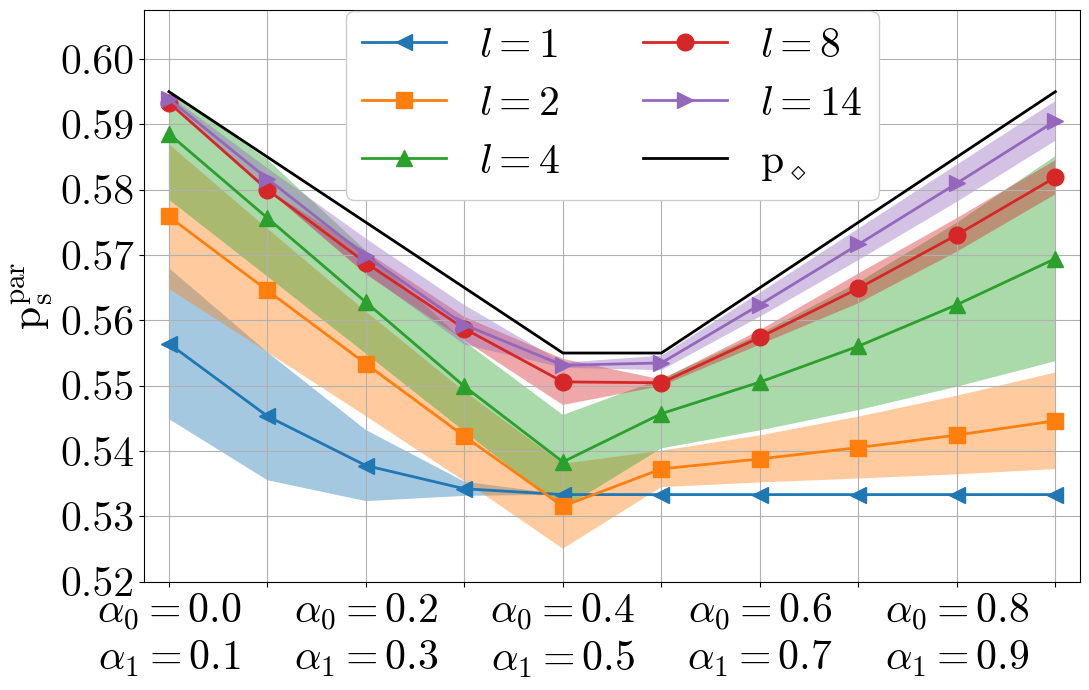

In [17]:
fontsize = 30
markersize = 12
linewidth = 2
plt.figure(figsize=(11, 7))
x_axis = np.arange(len(alphas)-1)
plt.plot(x_axis, p_sucs_par_1_means, marker="<", markersize=markersize, label=r"$l=1$", linewidth=linewidth)
plt.plot(x_axis, p_sucs_par_2_means, marker="s", markersize=markersize, label=r"$l=2$", linewidth=linewidth)
plt.plot(x_axis, p_sucs_par_4_means, marker="^", markersize=markersize, label=r"$l=4$", linewidth=linewidth)
plt.plot(x_axis, p_sucs_par_8_means, marker="o", markersize=markersize, label=r"$l=8$", linewidth=linewidth)
plt.plot(x_axis, p_sucs_par_14_means, marker=">", markersize=markersize, label=r"$l=14$", linewidth=linewidth)
plt.fill_between(x_axis, p_sucs_par_1_bound_l, p_sucs_par_1_bound_u, alpha=0.4)
plt.fill_between(x_axis, p_sucs_par_2_bound_l, p_sucs_par_2_bound_u, alpha=0.4)
plt.fill_between(x_axis, p_sucs_par_4_bound_l, p_sucs_par_4_bound_u, alpha=0.4)
plt.fill_between(x_axis, p_sucs_par_8_bound_l, p_sucs_par_8_bound_u, alpha=0.4)
plt.fill_between(x_axis, p_sucs_par_14_bound_l, p_sucs_par_14_bound_u, alpha=0.4)
plt.plot(x_axis, pdiams, marker=None, label=r"$\mathrm{p}_\diamond$", color="black", linewidth=linewidth)
plt.xticks(x_axis, [r"$\alpha_0="+str(alphas[i])+"$"+"\n" + r"$\alpha_1="+str(alphas[i+1])+"$" if i%2==0 else None for i in range(le)], fontsize=fontsize)
plt.yticks(np.arange(0.52, 0.64, 0.01), fontsize=fontsize)
plt.xlim(-0.25, 9.25)
plt.ylim(0.52, 0.6075)
plt.ylabel(r"$\mathrm{p_s^{par}}$", fontsize=fontsize)
plt.legend(loc="upper center", fontsize=fontsize, ncol=2, bbox_to_anchor=(0.5, 1.035), framealpha=1)#, bbox_to_anchor=(0.5, 0.675)
plt.grid()
plt.tight_layout()
# plt.savefig("psuc-par-l(2,14).pdf", bbox_inches='tight')
plt.show()

### Correlations

In [18]:
corrs_par_tp = [np.corrcoef(p_sucs_par_1_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_par_2_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_par_3_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_par_4_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_par_5_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_par_8_means, np.array(trpords))[0][1],
                np.corrcoef(p_sucs_par_14_means, np.array(trpords))[0][1],
           ]

corrs_par_dd = [np.corrcoef(p_sucs_par_1_means, diams)[0][1],
                np.corrcoef(p_sucs_par_2_means, diams)[0][1],
                np.corrcoef(p_sucs_par_3_means, diams)[0][1],
                np.corrcoef(p_sucs_par_4_means, diams)[0][1],
                np.corrcoef(p_sucs_par_5_means, diams)[0][1],
                np.corrcoef(p_sucs_par_8_means, diams)[0][1],
                np.corrcoef(p_sucs_par_14_means, diams)[0][1],
           ]
            
corrs_par_td = [np.corrcoef(p_sucs_par_1_means, trdists)[0][1],
                np.corrcoef(p_sucs_par_2_means, trdists)[0][1],
                np.corrcoef(p_sucs_par_3_means, trdists)[0][1],
                np.corrcoef(p_sucs_par_4_means, trdists)[0][1],
                np.corrcoef(p_sucs_par_5_means, trdists)[0][1],
                np.corrcoef(p_sucs_par_8_means, trdists)[0][1],
                np.corrcoef(p_sucs_par_14_means, trdists)[0][1],
           ]

corrs_par_fd = [np.corrcoef(p_sucs_par_1_means, fids)[0][1],
                np.corrcoef(p_sucs_par_2_means, fids)[0][1],
                np.corrcoef(p_sucs_par_3_means, fids)[0][1],
                np.corrcoef(p_sucs_par_4_means, fids)[0][1],
                np.corrcoef(p_sucs_par_5_means, fids)[0][1],
                np.corrcoef(p_sucs_par_8_means, fids)[0][1],
                np.corrcoef(p_sucs_par_14_means, fids)[0][1],
           ]

corrs_par_if = [np.corrcoef(p_sucs_par_1_means, infids)[0][1],
                np.corrcoef(p_sucs_par_2_means, infids)[0][1],
                np.corrcoef(p_sucs_par_3_means, infids)[0][1],
                np.corrcoef(p_sucs_par_4_means, infids)[0][1],
                np.corrcoef(p_sucs_par_5_means, infids)[0][1],
                np.corrcoef(p_sucs_par_8_means, infids)[0][1],
                np.corrcoef(p_sucs_par_14_means, infids)[0][1],
           ]

In [19]:
x_par = np.array([1, 2, 3, 4, 5, 8, 14])

def fitting_func_tp(x, a):#, b, c):
    # return a*x**(c) + b
    return x**(-1/a)
popt_mean_tp, pcov_mean_tp = curve_fit(fitting_func_tp, x_par, corrs_par_tp, bounds=(0, [10]), method=None)#
corrs_par_tp_fit = fitting_func_tp(x_par, *popt_mean_tp)

def fitting_func_td(x, a):#, b, c):
    # return a*x**(c) + b
    return x**(-1/a)
popt_mean_td, pcov_mean_td = curve_fit(fitting_func_td, x_par, corrs_par_td, bounds=(0, [10]), method=None)#
corrs_par_td_fit = fitting_func_td(x_par, *popt_mean_td)

def fitting_func_dd(x, a):#, b):
    # return a/x + b
    return 1 - np.exp(-x*a)
popt_mean_dd, pcov_mean_dd = curve_fit(fitting_func_dd, x_par, corrs_par_dd, bounds=(-10, [10]), method=None)#
corrs_par_dd_fit = fitting_func_dd(x_par, *popt_mean_dd)

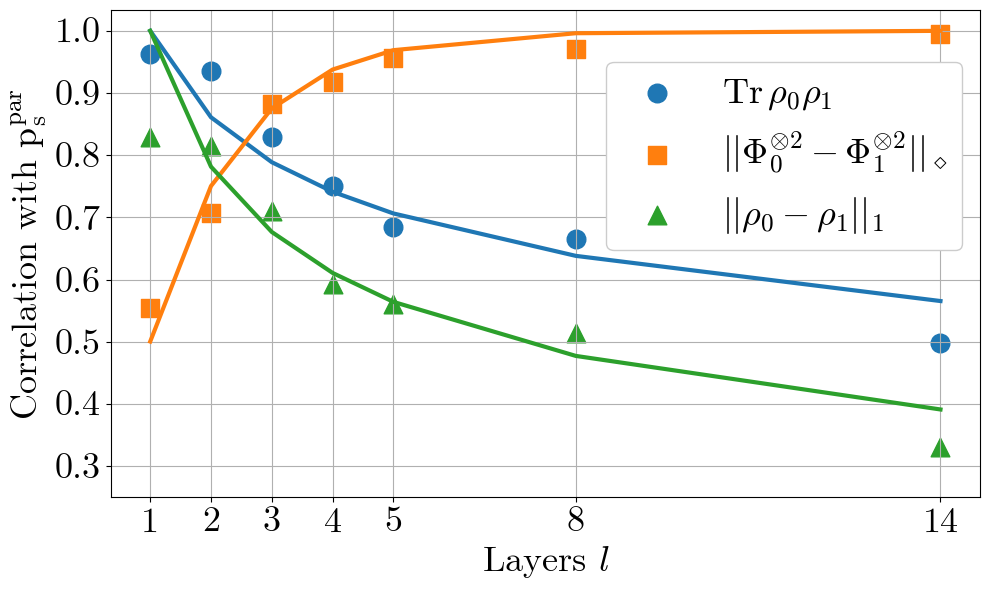

In [20]:
fontsize = 26
markersize = 180
linewidth = 3
plt.figure(figsize=(10, 6))
plt.scatter(x_par, corrs_par_tp, marker="o", label=r"$\mathrm{Tr}\, \rho_0 \rho_1$", color="C0", s=markersize)
plt.scatter(x_par, corrs_par_dd, marker="s", label=r"$||\Phi^{\otimes 2}_0 - \Phi_1^{\otimes 2}||_\diamond$", color="C1", s=markersize)
plt.scatter(x_par, corrs_par_td, marker="^", label=r"$||\rho_0 - \rho_1||_1$", color="C2", s=markersize)
plt.plot(x_par, corrs_par_tp_fit, color="C0", linewidth=linewidth)
plt.plot(x_par, corrs_par_dd_fit, color="C1", linewidth=linewidth)
plt.plot(x_par, corrs_par_td_fit, color="C2", linewidth=linewidth)
# plt.plot(x_axis, tds, marker=None, label=r"Trace distance (adjusted)", color="purple", linewidth=0.5)
plt.xticks(x_par, x_par, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"Layers $l$", fontsize=fontsize)
plt.ylabel(r"Correlation with $\mathrm{p_s^{par}}$", fontsize=fontsize)
plt.ylim(ymin=0.25)
# plt.title("Parallel", fontsize=fontsize)
plt.legend(loc=5, framealpha=1, fontsize=fontsize, bbox_to_anchor=(1., 0.7))
plt.grid()
plt.tight_layout()
plt.savefig("correlations-par.pdf", bbox_inches='tight')
plt.show()